In this notebook we will implement recommendation system based on Slope-One and SVD algorithms

The original paper of [Slope-one](https://arxiv.org/abs/cs/0702144) algorithm

We will explore [Movielens 100k dataset](https://grouplens.org/datasets/movielens/100k/) and compare the accuracy rate of the recommendation system built with 2 techiques:
1. The only Slop-One
2. SVD (low rank approximation) + Slope-One on the reduced matrix (The idea is taken from [this](https://www.atlantis-press.com/proceedings/mcei-15/25840929) paper)

## 1. Data vizualization

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
    * Simple demographic info for the users (age, gender, occupation, zip) (it is not used in our project)
    
- `ua.base` and `ua.test`   - are datasets the were obtained by split the `u.data` file into a training set and a test set with exactly 10 ratings per user in the test set.

In [28]:
import pandas as pd
import numpy as np
import sys

data = pd.read_csv('ml-100k/u.data', sep = '\t', names = ['user id', 'item id', 'rating', 'timestamp'])
data.drop('timestamp', axis = 1, inplace = True)

### Distribution of ratings

In [31]:
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

df = data['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = df.index,
               text = ['{:.1f} %'.format(val) for val in (df.values / data.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = df.values,
               )
# Create layout
layout = dict(title = 'Distribution of {} film-ratings'.format(data.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

#### Almost all films got rating $3$, $4$ and $5$

### Histogram of Number of Ratings Per Film

In [30]:
df = data.groupby('item id')['rating'].count().clip(upper = 100) # number of ratings per film if >100 then = 100

trace = go.Histogram(x = df.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 100,
                                  size = 2))

layout = go.Layout(title = 'Histogram of Number of Ratings Per Film ',
                   xaxis = dict(title = 'Number of Ratings per Film'),
                   yaxis = dict(title = 'Quantity of Films'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

#### The distribution is not normal. Most of films got just 1 rating

### Histogram of Number of Ratings Per User

In [32]:
df = data.groupby('user id')['rating'].count().clip(upper=50) # number of ratings which one user gave

# Create trace
trace = go.Histogram(x = df.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Histogram of Number of Ratings per User (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings given by user'),
                   yaxis = dict(title = 'Quantity of users'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [34]:
data = pd.read_csv('ml-100k/u.data', sep = '\t', names = ['user id', 'item id', 'rating', 'timestamp'])
data.drop('timestamp', axis = 1, inplace = True)

trace = go.Scatter3d(
    x = data['user id'][:200],  
    y = data['item id'][:200],  
    z = data['rating'][:200],  
    mode='markers',
    marker={
        'size': 5,
        'opacity': 0.8,
        'color' : data['rating'][:200],                
        'colorscale' : 'Viridis'
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0} 
)

df = [trace]

fig = go.Figure(data=df, layout=layout)


fig.update_layout(scene = dict(
                    xaxis_title='User',
                    yaxis_title='Movie',
                    zaxis_title='Rating'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

iplot(fig)

## 2. Data preprocessing

In [6]:
data = pd.read_csv('ml-100k/u.data', sep = '\t', names = ['user id', 'item id', 'rating', 'timestamp'])
df_base = pd.read_csv('ml-100k/ua.base',  sep='\t', names = ['user id', 'item id', 'rating', 'timestamp'])
df_test = pd.read_csv('ml-100k/ua.test', sep='\t', names = ['user id', 'item id', 'rating', 'timestamp'])

df_base.drop('timestamp', axis = 1, inplace = True)
df_test.drop('timestamp', axis = 1, inplace = True)
data.drop('timestamp', axis = 1, inplace = True)

print('whole data:', data.shape)
print('train data:', df_base.shape)
print('test data:', df_test.shape)

whole data: (100000, 3)
train data: (90570, 3)
test data: (9430, 3)


In [7]:
df_base.head(10)

,user id,item id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
5,1,6,5
6,1,7,4
7,1,8,1
8,1,9,5
9,1,10,3


#### Transform dataset into User-Item matrix

In [8]:
USER_NUM = 943
ITEM_NUM = 1682

def trans_to_mat(df):
    matrix = np.zeros((USER_NUM, ITEM_NUM))
    for i, data in df.iterrows():
        matrix[data[0] - 1][data[1] - 1] = data[2]
    return matrix


data = trans_to_mat(data)
base_mat = trans_to_mat(df_base)
test_mat = trans_to_mat(df_test)

print('whole data:', data.shape)
print('train data:', base_mat.shape)
print('test data:', test_mat.shape)

whole data: (943, 1682)
train data: (943, 1682)
test data: (943, 1682)


## User-Item matrix

In [49]:
base_mat

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [50]:
print('Sparsity of matrix is:', round(np.count_nonzero(base_mat)/(base_mat.shape[0] * base_mat.shape[1]),3))

Sparsity of matrix is: 0.057


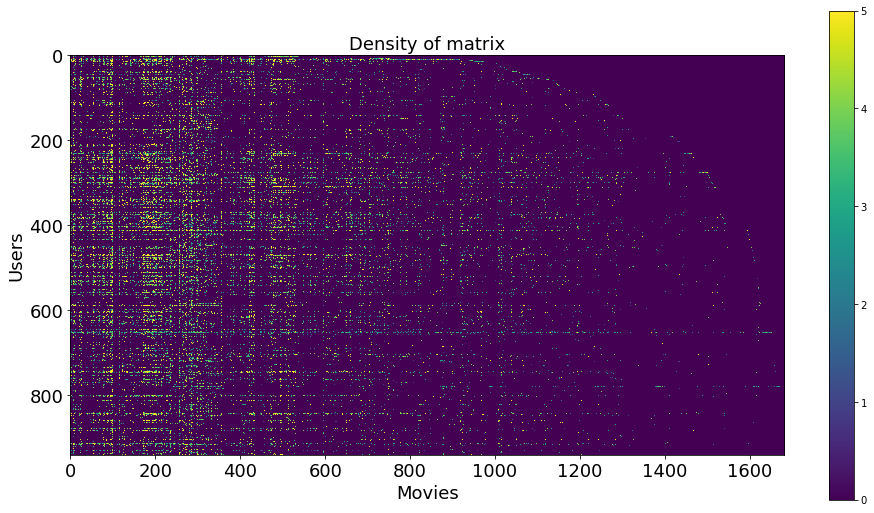

In [42]:
plt.figure(figsize = (16,9))
plt.title('Density of matrix', fontsize = 18)

plt.imshow(base_mat)
plt.colorbar()
plt.xlabel('Movies', fontsize = 18)
plt.ylabel('Users', fontsize = 18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

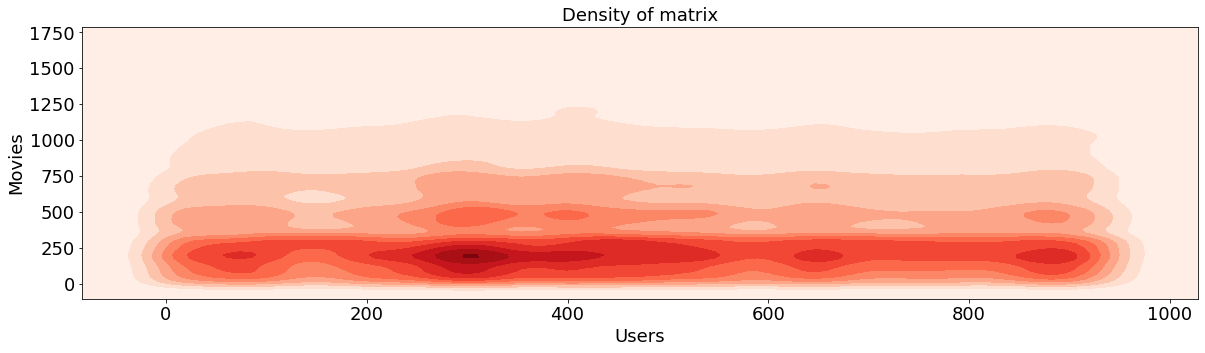

In [60]:
import seaborn as sns
plt.figure(figsize=(20,5))
plt.title('Density of matrix', fontsize = 18)
sns.kdeplot(data = data, cmap="Reds", shade=True)
plt.xlabel('Users', fontsize = 18)
plt.ylabel('Movies', fontsize = 18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

### With the help of last two graphs we are able to lessen the time of execution of our code by simple checks. We can see that movies to the end are not rated

#### Next 3 cells can help to understand how train and test data looks like

In [16]:
base_mat[0][:100]

array([5., 3., 4., 3., 3., 5., 4., 1., 5., 3., 2., 5., 5., 5., 5., 5., 3.,
       4., 5., 0., 1., 4., 4., 3., 4., 3., 2., 4., 1., 3., 3., 5., 0., 2.,
       1., 2., 2., 3., 4., 3., 2., 5., 4., 5., 5., 4., 4., 5., 3., 5., 4.,
       4., 3., 3., 5., 4., 5., 4., 5., 5., 0., 3., 2., 5., 4., 4., 3., 4.,
       3., 3., 3., 4., 3., 1., 4., 4., 4., 1., 4., 4., 5., 5., 3., 4., 3.,
       5., 5., 4., 5., 4., 5., 3., 5., 2., 4., 5., 3., 4., 3., 5.])

In [17]:
test_mat[0][:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
data[0][:100]

array([5., 3., 4., 3., 3., 5., 4., 1., 5., 3., 2., 5., 5., 5., 5., 5., 3.,
       4., 5., 4., 1., 4., 4., 3., 4., 3., 2., 4., 1., 3., 3., 5., 4., 2.,
       1., 2., 2., 3., 4., 3., 2., 5., 4., 5., 5., 4., 4., 5., 3., 5., 4.,
       4., 3., 3., 5., 4., 5., 4., 5., 5., 4., 3., 2., 5., 4., 4., 3., 4.,
       3., 3., 3., 4., 3., 1., 4., 4., 4., 1., 4., 4., 5., 5., 3., 4., 3.,
       5., 5., 4., 5., 4., 5., 3., 5., 2., 4., 5., 3., 4., 3., 5.])

#### We see that base_mat and test_mat are compound of data indeed

### Let's look on rank of our matrix user-item

In [64]:
from numpy.linalg import matrix_rank
print('The rank of matrix is :', matrix_rank(base_mat))
print('The size of matrix is :', base_mat.shape)

The rank of matrix is : 943
The size of matrix is : (943, 1682)


### It is full-rank matrix!! And actually it was predictably, because it is sparse matrix. 
* We can assume example of identity matrix with big sizes. It is of full-rank and sparse matrix.

### Singular values of User-Item matrix and its Low-Aproximation matrix

In [65]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

u, sigma, v = svd(base_mat)

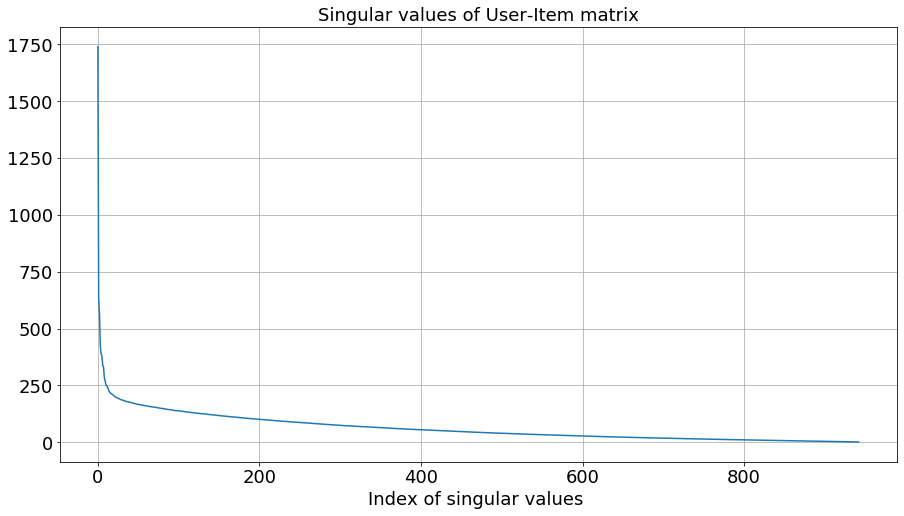

In [69]:
plt.figure(figsize = [15,8])
plt.title('Singular values of User-Item matrix', fontsize = 18)
plt.plot(sigma[::]/sigma[-1])
plt.xlabel("Index of singular values ", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

## 3. Slope-One

#### Notations:

$u$ - the ratings of all the watched films given by the user (np.array - row of the main matrix)
- $S(u)$ - the set of items which have the rating value in $u$ row
- $\chi$ -  the set of all evaluations in the training set
- $card(S)$ -  the number of elements in a set $S$ 
- $S_i(\chi)$ - the set of all evaluations $u \in \chi$ whivh contain item $i$ (non-zero)rating

In this project we implement weighted Slope-one Scheme

Given a training set $\chi$, and any two items $j$ and $i$ with ratings $u_j$ and $u_i$ respectively in some user evaluation $u$ (annotated as $u \in S_{ji}(\chi)$),  the average deviation of item $i$ with respect to item $j$ is:

$$dev_{ij} = \sum_{u \in S_{ji}(\chi)} \dfrac{u_j-u_i}{card(S_{ji}(\chi))}$$

Then, we define the WEIGHTED SLOPE ONE prediction as the following weighted average

$$P(u)_j^{weighted} = \dfrac{\sum_{i \in S(u)-j} (dev_{ji}+u_i)c_{ji}}{\sum_{i \in S(u)-j}c_{ji}}$$

where $c_{ji} = card(S_{ji}(\chi))$

In [246]:
def weighted_slope_one(input_mat):
    user_num = input_mat.shape[0]
    item_num = input_mat.shape[1]
    
    def get_deviation(i, j):
        """
        function calculates deviation of items i and j
        @param item pair
        @return average deviation value and nb of users who evaluated both movies i & j
        """
        dev_ij = 0
        users = 0 # nb of users who evaluated both movies i & j
        for row in range(user_num):
            # if the user evaluated both movie i and movie j
            if (input_mat[row][i] != 0) and (input_mat[row][j] != 0):  # trouble
                users += 1
                dev_ij += input_mat[row][i] - input_mat[row][j]
        
        # avoid zero division
        if(users == 0):
            deviation = 0
        else:
            deviation = dev_ij / users
        return deviation, users

    dev = np.zeros((item_num, item_num)) # average deviation matrix
    evaled_users_mat = np.zeros((item_num, item_num)) # matrix of card(S_{ji})  
    
    for i in range(item_num):
        for j in range(item_num):
            if i == j:
                # to lessen the time complexity
                break
            else:
                dev_temp, users = get_deviation(i, j)
                dev[i][j] = dev_temp
                dev[j][i] = (-1) * dev_temp
                evaled_users_mat[i][j] = users
                evaled_users_mat[j][i] = users
    
    # get the prediction matrix
    pred_mat = np.zeros((user_num, item_num))
    for user in range(user_num):
        eval_row = np.where(input_mat[user] != 0)[0] # indices of items rating unequal to 0 in row u 
        
        for j in range(item_num):
            numerator = np.sum((dev[j][eval_row] + input_mat[user][eval_row]) * evaled_users_mat[j][eval_row])
            denominator = np.sum(evaled_users_mat[j][eval_row])
            
            pred_mat[user][j] = numerator / denominator
                
    return pred_mat

In [251]:
# predict = weighted_slope_one(base_mat)

predict = pd.read_csv('pred_mat_only_slope1.csv')
predict = np.array(predict)
predict

array([[4.0516324 , 3.36679603, 3.18347222, ..., 1.875     , 3.37956204,
        3.30344828],
       [3.95539186, 3.36817654, 3.11007338, ..., 1.55      , 3.65      ,
        3.54545455],
       [3.15378389, 2.56666667, 2.33905013, ..., 1.9       , 3.        ,
        2.        ],
       ...,
       [3.86960065, 3.37632509, 3.31372549, ..., 1.5       , 3.42857143,
        3.33333333],
       [4.36890524, 3.77216495, 3.51703878, ..., 2.47058824, 3.57142857,
        3.72727273],
       [3.87576983, 3.22080076, 3.0698324 , ...,        nan, 3.46728972,
        3.26315789]])

## 4. Measure the errors

#### In accordance with the [article](https://www.atlantis-press.com/proceedings/mcei-15/25840929) we measure errors through RMSE and MAE 

In [248]:
import math


def RMSE(predict, correct):
    pred = predict[np.where((correct > 0) & (~np.isnan(predict)))]
    cor = correct[np.where((correct > 0) & (~np.isnan(predict)))]
    return math.sqrt(np.average((pred - cor) ** 2))

def MAE(predict, correct):
    pred = predict[np.where((correct > 0) & (~np.isnan(predict)))]
    cor = correct[np.where((correct > 0) & (~np.isnan(predict)))]
    return np.average(np.abs(pred - cor))


In [252]:
print('RMSE:', round(RMSE(predict, test_mat), 3))
print('MAE:', round(MAE(predict, test_mat), 3))

RMSE: 0.961
MAE: 0.756
